In [1]:
spark

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 6, Finished, Available, Finished)

In [13]:
workspace_default_storage_account = "projectgstoragedfb938a3e"
workspace_default_container = "azureml-blobstore-becc8696-e562-432e-af12-8a5e3e1f9b0f"
workspace_wasbs_base_url = f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 36, Finished, Available, Finished)

In [17]:
from pyspark.sql.functions import lit
import pandas

cancer_path = f"{workspace_wasbs_base_url}cancer_subreddit_sentiment.parquet"
cancer_df = spark.read.parquet(cancer_path)

not_cancer_path = f"{workspace_wasbs_base_url}not_cancer_subreddit_sentiment.parquet"
not_cancer = spark.read.parquet(not_cancer_path)

cancer_df = cancer_df.withColumn("source", lit("cancer"))

not_cancer = not_cancer.withColumn("source", lit("non_cancer"))

df = cancer_df.union(not_cancer)
df = df.select('text', 'source')

df = df.toPandas()

df.head()

cancer_df = cancer_df.select('text')
cancer_df = cancer_df.toPandas()

not_cancer_df = not_cancer.select('text')
not_cancer_df = not_cancer.toPandas()

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 40, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: ArrayType(StructType([StructField('annotatorType', StringType(), True), StructField('begin', IntegerType(), True), StructField('end', IntegerType(), True), StructField('result', StringType(), True), StructField('metadata', MapType(StringType(), StringType(), True), True), StructField('embeddings', ArrayType(FloatType(), True), True)]), True)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [15]:
df = df[['text']]
df = df.rename(columns={'text': 'text_column'})
df.head()

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 38, Finished, Available, Finished)

,text_column
0,"Check out Northside Hospital -Atlanta, Piedmon..."
1,I had something similar and managed to get it ...
2,"That's an insulting offer, and I'm a LPN. Out ..."
3,"Yeah sorry, it was my mistake. I meant to say ..."
4,I see my colorectal dr tomorrow. My disease is...


In [2]:
%pip install nrclex

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 11, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 KB 10.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... - done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43311 sha256=62a0d867d52174a4931923eba8cd87aa9241eef9b378222020903444d08853a4
  Stored in directory: /home/trusted-service-user/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built nrclex
You should consider upgrading via the '/nfs4/pyenv-6627d8c9-a15c-456d-9489-cde0558b7230/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import nrclex
import nltk
from multiprocessing import Pool

# Download NLTK data for tokenization
nltk.download('punkt')

# Sample dataframe with a text column
#data = {'text_column': ["I love coding!", "I hate bugs in my code.", "This is a neutral statement.", 
#                        "I enjoy solving problems!", "I get frustrated when things don't work."]}
#df = pd.DataFrame(data)

# Define a function to get sentiment from NRC lexicon
def get_sentiment(text):
    if isinstance(text, str):
        # Initialize NRC lexicon for each text
        nrc_lex = nrclex.NRCLex(text)
        affect_frequencies = nrc_lex.affect_frequencies
        
        # Extracting positive, negative, neutral, and other emotions including 'trust'
        sentiment = {
            "positive": affect_frequencies.get("positive", 0),
            "negative": affect_frequencies.get("negative", 0),
            "neutral": affect_frequencies.get("neutral", 0),
            "anger": affect_frequencies.get("anger", 0),
            "fear": affect_frequencies.get("fear", 0),
            "disgust": affect_frequencies.get("disgust", 0),
            "sadness": affect_frequencies.get("sadness", 0),
            "joy": affect_frequencies.get("joy", 0),
            "surprise": affect_frequencies.get("surprise", 0),
            "trust": affect_frequencies.get("trust", 0)  # Added trust emotion
        }
        return sentiment
    return {
        "positive": 0, "negative": 0, "neutral": 0, "anger": 0, "fear": 0, 
        "disgust": 0, "sadness": 0, "joy": 0, "surprise": 0, "trust": 0  # Default 0 for all emotions
    }

# Function to process a chunk of data
def process_chunk(chunk):
    chunk[['positive', 'negative', 'neutral', 'anger', 'fear', 'disgust', 'sadness', 'joy', 'surprise', 'trust']] = \
        chunk['text'].apply(get_sentiment).apply(pd.Series)
    return chunk

# Function to split dataframe into chunks
def split_dataframe(df, num_chunks):
    chunk_size = len(df) // num_chunks
    return [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

# Number of chunks for parallel processing (adjust based on your system's cores)
num_chunks = 4  # or a value that suits your setup

# Split the DataFrame into chunks
chunks = split_dataframe(cancer_df, num_chunks)

# Use multiprocessing to process the chunks in parallel
with Pool(processes=num_chunks) as pool:
    result_chunks = pool.map(process_chunk, chunks)

# Combine the processed chunks back into a single DataFrame
cancer_final_df = pd.concat(result_chunks, ignore_index=True)

# Display the final dataframe with sentiment columns
print(cancer_final_df)


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 20, Finished, Available, Finished)

[nltk_data] Downloading package punkt to /home/trusted-service-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                                   text  positive  negative  \
0     Check out Northside Hospital -Atlanta, Piedmon...  0.198020  0.089109   
1     I had something similar and managed to get it ...  0.666667  0.000000   
2     That's an insulting offer, and I'm a LPN. Out ...  0.275862  0.103448   
3     Yeah sorry, it was my mistake. I meant to say ...  0.000000  0.500000   
4     I see my colorectal dr tomorrow. My disease is...  0.000000  0.166667   
...                                                 ...       ...       ...   
9995  I’m also starting my chemo this Thursday! My a...  0.058824  0.235294   
9996  Yes it disappeared I don’t remember how long i...  0.333333  0.000000   
9997                       may I ask how late were you?  0.000000  0.500000   
9998  Yes I made this post initially because I was v...  0.391304  0.043478   
9999  The general health panel is not on the ACAs li...  0.333333  0.333333   

      neutral     anger      fear   disgust   sadne

In [7]:
# Split the DataFrame into chunks
chunks = split_dataframe(not_cancer_df, num_chunks)

# Use multiprocessing to process the chunks in parallel
with Pool(processes=num_chunks) as pool:
    result_chunks = pool.map(process_chunk, chunks)

# Combine the processed chunks back into a single DataFrame
non_cancer_final_df = pd.concat(result_chunks, ignore_index=True)

# Display the final dataframe with sentiment columns
print(non_cancer_final_df)

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 21, Finished, Available, Finished)

                                                   text  \
0     It’s like saying “no offense, but…” and then s...   
1                                      It was fake man.   
2     No, you cannot combine MD accounts; each has i...   
3                   Wiser words have never been spoken.   
4     Cara vai sem pressa, mata td que tu ver pela f...   
...                                                 ...   
9995  Switch update was just a normal firmware updat...   
9996                                          [removed]   
9997  When will someone just fucking follow glorious...   
9998                                  Ew, STFU already.   
9999  Szemely szerint csak bemutatkoznek neki udvari...   

                                               document  \
0     [(document, 0, 71, It’s like saying “no offens...   
1     [(document, 0, 15, It was fake man., {'sentenc...   
2     [(document, 0, 210, No, you cannot combine MD ...   
3     [(document, 0, 34, Wiser words have never been...

In [8]:
cancer_final_df['Source'] = 'Cancer'
non_cancer_final_df['Source'] = 'Non-Cancer'

df_combined = pd.concat([cancer_final_df, non_cancer_final_df], ignore_index=True)

print(df_combined.head())

columns_to_keep = ['Source', 'positive', 'negative', 'neutral', 'anger', 'fear', 
                   'disgust', 'sadness', 'joy', 'surprise', 'trust']

df_sentiment_both = df_combined[columns_to_keep]

print(df_sentiment_both.head())


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 22, Finished, Available, Finished)

                                                text  positive  negative  \
0  Check out Northside Hospital -Atlanta, Piedmon...  0.198020  0.089109   
1  I had something similar and managed to get it ...  0.666667  0.000000   
2  That's an insulting offer, and I'm a LPN. Out ...  0.275862  0.103448   
3  Yeah sorry, it was my mistake. I meant to say ...  0.000000  0.500000   
4  I see my colorectal dr tomorrow. My disease is...  0.000000  0.166667   

   neutral     anger      fear   disgust   sadness       joy  surprise  \
0      0.0  0.049505  0.079208  0.039604  0.059406  0.128713  0.059406   
1      0.0  0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
2      0.0  0.057471  0.057471  0.045977  0.068966  0.080460  0.068966   
3      0.0  0.000000  0.000000  0.000000  0.500000  0.000000  0.000000   
4      0.0  0.166667  0.166667  0.166667  0.166667  0.000000  0.000000   

      trust  Source document sentence token checked sentiment source  
0  0.138614  Cancer      Na

In [9]:
print(df_sentiment_both.head())

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 23, Finished, Available, Finished)

   Source  positive  negative  neutral     anger      fear   disgust  \
0  Cancer  0.198020  0.089109      0.0  0.049505  0.079208  0.039604   
1  Cancer  0.666667  0.000000      0.0  0.000000  0.333333  0.000000   
2  Cancer  0.275862  0.103448      0.0  0.057471  0.057471  0.045977   
3  Cancer  0.000000  0.500000      0.0  0.000000  0.000000  0.000000   
4  Cancer  0.000000  0.166667      0.0  0.166667  0.166667  0.166667   

    sadness       joy  surprise     trust  
0  0.059406  0.128713  0.059406  0.138614  
1  0.000000  0.000000  0.000000  0.000000  
2  0.068966  0.080460  0.068966  0.149425  
3  0.500000  0.000000  0.000000  0.000000  
4  0.166667  0.000000  0.000000  0.000000  


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 24, Finished, Available, Finished)

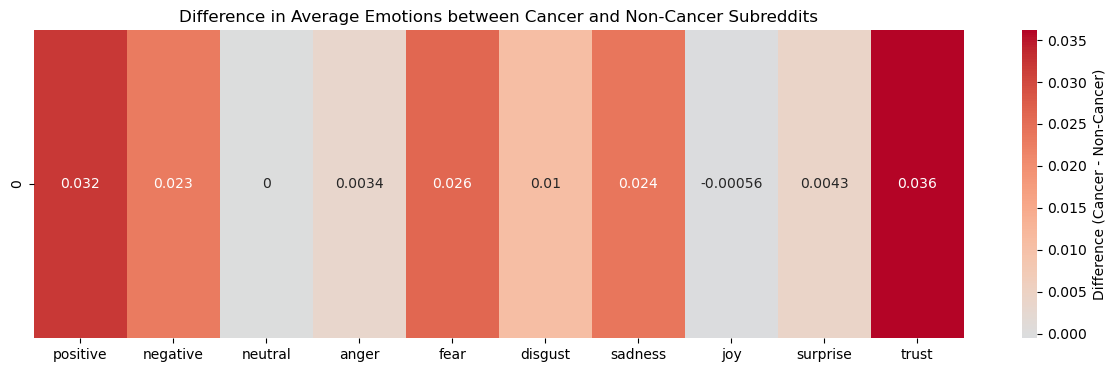

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
df_grouped = df_sentiment_both.groupby('Source').mean()

# Step 2: Calculate the difference between Cancer and Non-Cancer
difference = df_grouped.loc['Cancer'] - df_grouped.loc['Non-Cancer']

# Step 3: Create a heatmap to show the difference
plt.figure(figsize=(15, 4))
sns.heatmap(difference.to_frame().T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Difference (Cancer - Non-Cancer)'})
plt.title('Difference in Average Emotions between Cancer and Non-Cancer Subreddits')
plt.savefig("Users/tvl8/fall-2024-project-team-35/code/images/nrc_lex_heatmap.png", format='png', bbox_inches='tight', dpi=300)
plt.show()

The difference for "positive" is positive, it means Cancer patients tend to have higher "positive" values than Non-Cancer patients.
The difference for "joy" is negative, it means Non-Cancer patients have higher "joy" values than Cancer patients.

In [31]:
print(df_grouped)

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 54, 63, Finished, Available, Finished)

            positive  negative  neutral     anger      fear   disgust  \
Source                                                                  
Cancer      0.202806  0.119079      0.0  0.037681  0.067383  0.033798   
Non-Cancer  0.170739  0.096125      0.0  0.034273  0.041384  0.023316   

             sadness       joy  surprise     trust  
Source                                              
Cancer      0.058226  0.044399  0.028933  0.119079  
Non-Cancer  0.034463  0.044963  0.024675  0.082917  


| subreddit     | positive | negative | neutral | anger   | fear    | disgust | sadness | joy     | surprise | trust   |
|------------|----------|----------|---------|---------|---------|---------|---------|---------|----------|---------|
| Cancer     | 0.202806 | 0.119079 | 0.0     | 0.037681 | 0.067383 | 0.033798 | 0.058226 | 0.044399 | 0.028933 | 0.119079 |
| Non-Cancer | 0.170739 | 0.096125 | 0.0     | 0.034273 | 0.041384 | 0.023316 | 0.034463 | 0.044963 | 0.024675 | 0.082917 |


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 54, 64, Finished, Available, Finished)

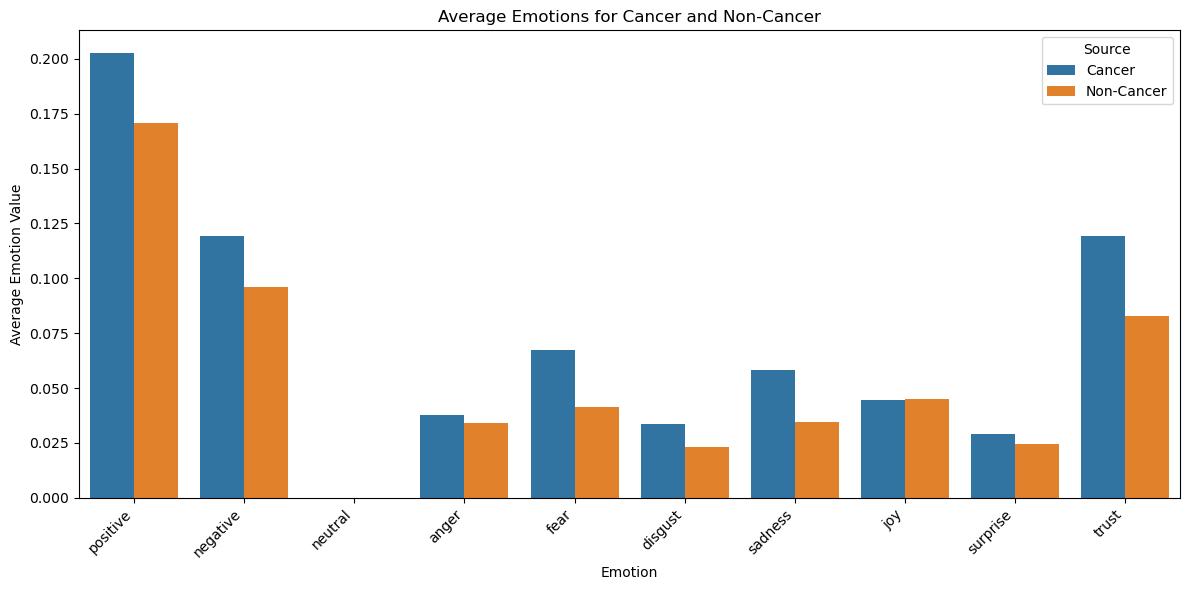

In [32]:
# Step 2: Melt the DataFrame for easy plotting
df_melted = df_grouped.reset_index().melt(id_vars='Source', var_name='Emotion', value_name='Average')

# Step 3: Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Emotion', y='Average', hue='Source', data=df_melted)

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.title('Average Emotions for Cancer and Non-Cancer')
plt.ylabel('Average Emotion Value')
plt.xlabel('Emotion')

# Show plot
plt.tight_layout()
plt.show()

In [34]:
print(df_melted)
df_melted.to_csv('Users/tvl8/fall-2024-project-team-35/code/nrc_lex_averages.csv', index=False)

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 54, 66, Finished, Available, Finished)

        Source   Emotion   Average
0       Cancer  positive  0.202806
1   Non-Cancer  positive  0.170739
2       Cancer  negative  0.119079
3   Non-Cancer  negative  0.096125
4       Cancer   neutral  0.000000
5   Non-Cancer   neutral  0.000000
6       Cancer     anger  0.037681
7   Non-Cancer     anger  0.034273
8       Cancer      fear  0.067383
9   Non-Cancer      fear  0.041384
10      Cancer   disgust  0.033798
11  Non-Cancer   disgust  0.023316
12      Cancer   sadness  0.058226
13  Non-Cancer   sadness  0.034463
14      Cancer       joy  0.044399
15  Non-Cancer       joy  0.044963
16      Cancer  surprise  0.028933
17  Non-Cancer  surprise  0.024675
18      Cancer     trust  0.119079
19  Non-Cancer     trust  0.082917


In [11]:
%pip install wordcloud

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 29, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 KB 17.1 MB/s eta 0:00:00
You should consider upgrading via the '/nfs4/pyenv-6627d8c9-a15c-456d-9489-cde0558b7230/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

cancer_df_pd = cancer_df[['text']]


custom_stop_words = ENGLISH_STOP_WORDS.union({"just", "like", "don", "https", "use", "does",
 "post", "subreddit", "know", "ve", "com", "www", "reddit", "message", "think", "good", 
 "automatically", "0a", "askdocs", "bot", "terms", "20relevant", "compose", "bad", "moderators",
 "submit", "did", "comments"})

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, max_features=20)  # You can adjust max_features as needed

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(cancer_df_pd['text'])

# Get the feature names (words) and their corresponding TF-IDF values
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Sum of TF-IDF scores for each term

# Create a DataFrame with words and their TF-IDF scores
tfidf_df = pd.DataFrame(list(zip(feature_names, tfidf_scores)), columns=['word', 'tfidf'])
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)

# Display the top 10 important words by TF-IDF
print(tfidf_df.head(10))


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 42, Finished, Available, Finished)

           word       tfidf
17         time  604.333288
15      removed  510.072719
16        thank  508.752837
8   information  491.421062
6        doctor  480.772518
11       people  467.593201
19         work  443.772165
10      patient  387.074392
3        cancer  365.678933
2          best  340.635342


|   word    |   TF-IDF   |
|-----------|-----------|
| cancer    | 15.245    |
| treatment | 10.458    |
| pain      | 8.345     |
| doctor    | 7.234     |
| hospital  | 6.983     |
| patient   | 6.453     |
| chemo     | 5.987     |
| tumor     | 5.124     |
| symptoms  | 4.852     |
| therapy   | 4.657     |


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 62, 44, Finished, Available, Finished)

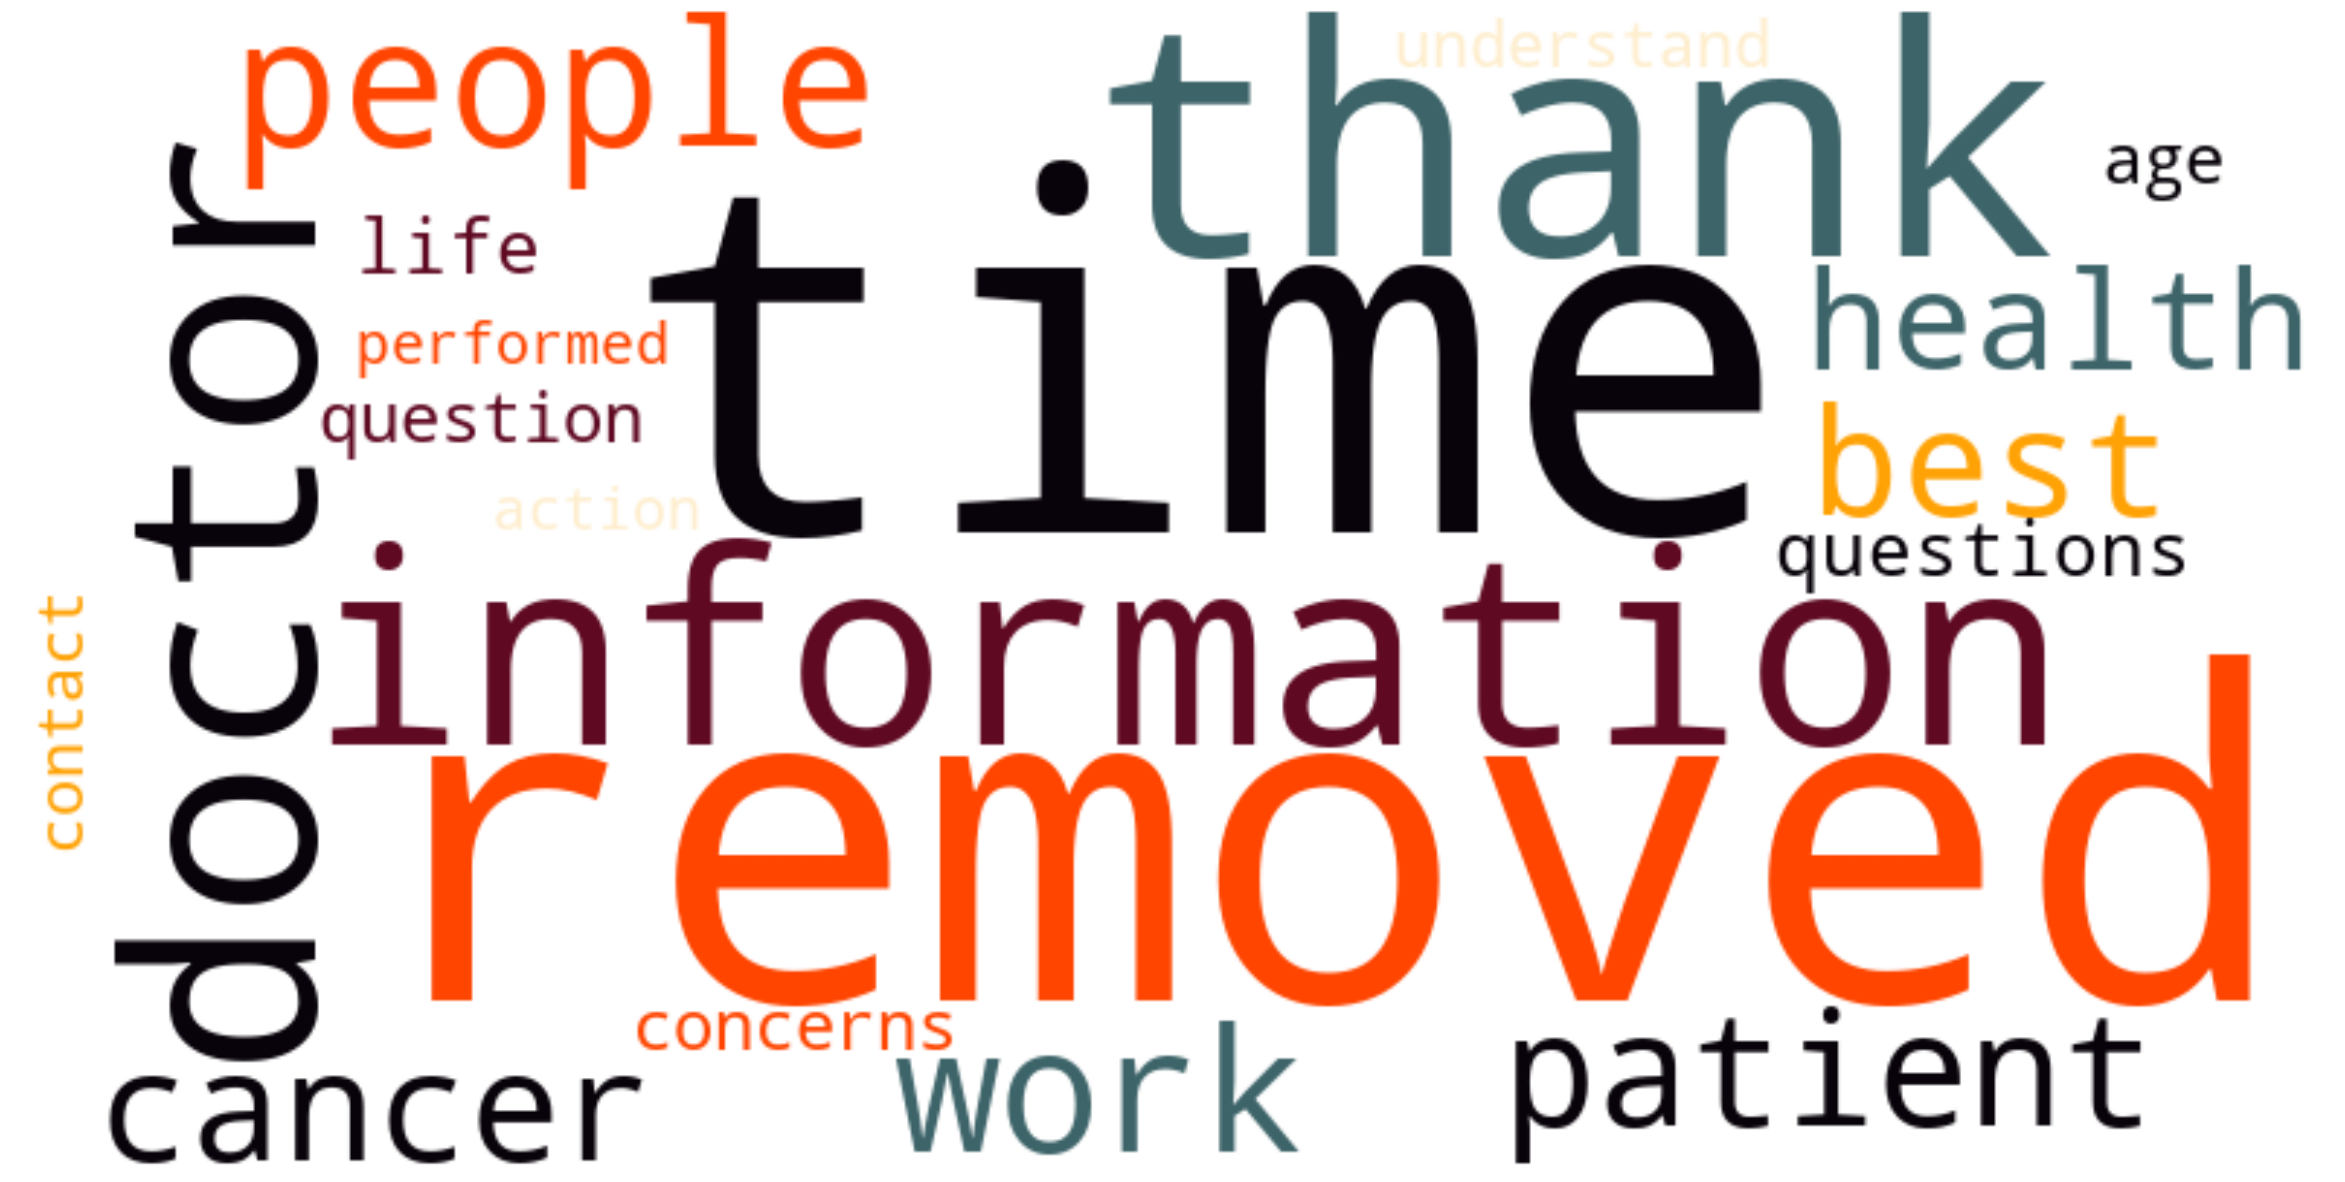

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np


hex_colors = [
    "#3d6469", "#ffa205", "#ff4500", "#08030a", "#feeece", "#d40637", "#5f0922"
]

# Custom color function to cycle through the colors
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Use the hash of the word to ensure consistent coloring
    color_index = hash(word) % len(hex_colors)
    return hex_colors[color_index]


# Convert the TF-IDF dataframe into a dictionary
word_freq = dict(zip(tfidf_df['word'], tfidf_df['tfidf']))

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

wordcloud = wordcloud.recolor(color_func=custom_color_func)

plt.figure(figsize=(30, 30))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.savefig("Users/tvl8/fall-2024-project-team-35/code/images/wordcloud.png", format='png', bbox_inches='tight', dpi=300)
plt.show()




Visualize
Produce at least 3 interesting graphs about your resulting dataset. Think about the dimensions that are interesting for your Reddit data. There are millions of choices. Make sure your graphs are connected to your analytical questions.
Summary tables
Produce at least 3 interesting tables about your resulting dataset. You can decide how to split up your data into categories, time slices, etc. There are infinite ways you can make summary statistics. Be unique, creative, and interesting!